In [3]:
import numpy as np
import jax.numpy as jnp
from jax.example_libraries import optimizers
from jax import grad, jit, random
import matplotlib.pyplot as plt
import sys

import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
# solve deeper case for the Phi, hatPhi

def linear_deep_Bayes(C, y, L, gamma, up_step_Phi = 0.1, up_step_hatPhi = 0.01, steps = 100, inner_steps =100, beta = 100.0):

    Phis = [ C for l in range(L) ]
    hatPhis = [ jnp.zeros(C.shape) for l in range(L) ]


    def action(Phis, hatPhis):

    S = 0.0
    for l in range(L):
        S += - 0.5 * jnp.sum( Phis[l] * hatPhis[l] )

    S += 0.5 * gamma**2 * jnp.dot(y , jnp.linalg.solve(Phis[-1] + 1.0/beta * jnp.eye(y.shape[0]), y) )

    # ln det( I + C hatPhi^1  )
    _, log_det = jnp.linalg.slogdet( jnp.eye(C.shape[0]) + C @ hatPhis[0] )
    S += 0.5 * log_det

    for l in range(L-1):
      # ln det( I + Phi^{l-1} @ hatPhi^{l} )
        _, log_det = jnp.linalg.slogdet( jnp.eye(C.shape[0]) + Phis[l] @ hatPhis[l+1] )
        S += 0.5 * log_det

    return S


    grad_Phi = jit( grad(action, 0) )
    grad_hatPhi = jit( grad( lambda a,b: -1.0 * action(a,b) , 1) )

    # train phi_sqrt , Phi = phi_sqrt.T @ phi_sqrt
    opt_init_1, opt_update_1, get_params_1 = optimizers.momentum( up_step_Phi , 0.9 )
    opt_init_2, opt_update_2, get_params_2 = optimizers.momentum( up_step_hatPhi , 0.9 )


    opt_state_phi = opt_init_1(Phis)
    opt_state_hatphi = opt_init_2(hatPhis)


    action_vals = []

    aligns = []
    for step in range(steps):
    action_value = action( get_params_1(opt_state_phi) , get_params_2(opt_state_hatphi) )
    action_vals += [action_value]



    sys.stdout.write(f'\r step: {step}, action: {action_value}')
    for inner_step in range(inner_steps):
        # in this loop we try max on hatPhi, use -1 * gradient
        Phi_sym = [ 0.5 * (phi + phi.T) for phi in get_params_1(opt_state_phi) ]
        hat_Phi_sym = [ 0.5* (hatphi + hatphi.T) for hatphi in get_params_2(opt_state_hatphi) ]

        opt_state_hatphi = opt_update_2(inner_step, grad_hatPhi( Phi_sym, hat_Phi_sym  ), opt_state_hatphi)

    Phi_sym = [ 0.5* (phi + phi.T) for phi in get_params_1(opt_state_phi) ]
    hat_Phi_sym = [ 0.5* (hatphi + hatphi.T) for hatphi in get_params_2(opt_state_hatphi) ]

    opt_state_phi = opt_update_1(step, grad_Phi( Phi_sym, hat_Phi_sym ), opt_state_phi)
    aligns +=  [ [ jnp.dot(y, phi @ y) for phi in Phi_sym ] ]

    Phis_final = get_params_1(opt_state_phi)
    hatPhis_final = get_params_2(opt_state_hatphi)

    return Phis_final, hatPhis_final, action_vals, aligns

In [3]:
def phi_fn(h, g=1.0):
    #return jnp.maximum(0, g * h)
    return jnp.tanh(g*h)

def init_kernels(C, g=1.0, samples=10000, seed=0):
    key = random.PRNGKey(seed)
    P = C.shape[0]

    sqrt_C = sqrt_svd(C)
    h = random.normal(key, (samples, P)) @ sqrt_C
    phi_h = phi_fn(h, g=g)

    init_Phi = 1 / phi_h.shape[0] * phi_h.T @ phi_h

    return init_Phi

def sqrt_svd(Sigma, eps=0.0):
    s, v = jnp.linalg.eigh(Sigma + eps*jnp.eye(Sigma.shape[0]))
    s = s * (s > 0.0)  # Ensure non-negative eigenvalues
    return v @ jnp.diag(jnp.sqrt(s)) @ v.T

def generate_samples(Phi, samples, key):
    P = Phi.shape[0]
    sqrt_Phi = sqrt_svd(Phi)

    h = random.normal(key,(samples, P)) @ sqrt_Phi
    return h

def single_site(Phi_prev, hat_Phi, samples, key):
    key, subkey = random.split(key)
    h = generate_samples(Phi_prev, samples, subkey)
    phi_h = phi_fn(h)
    exp_term = jnp.exp(-0.5 * jnp.einsum('bi,ij,bj->b', phi_h, hat_Phi, phi_h))
    normalization = jnp.mean(exp_term)
    log_exp = jnp.log(normalization)

    return log_exp

In [4]:
def nonlinear_deep_Bayes(C, y, L, gamma, beta, seed, up_step_Phi=0.001, up_step_hatPhi=0.001, steps=400, inner_steps=100, samples=40000):
    key = random.PRNGKey(seed)
    Phis = [init_kernels(C) ]
    for l in range(L-1):
        Phis += [ init_kernels(Phis[-1]) ]
    hatPhis = [jnp.zeros(C.shape) for _ in range(L)]

    @jit
    def action(Phis, hatPhis, key):
        key, key_site0 = random.split(key)
        S = 0.0

        # Quadratic term: -0.5 * sum_l Phi_l * hatPhi_l
        for l in range(L):
            S -= 0.5 * jnp.sum(Phis[l] * hatPhis[l])

        # Energy term: 0.5 * gamma^2 * y^T (Phi_L)^{-1} y
        energy_term = 0.5 * gamma**2 * jnp.dot(y, jnp.linalg.solve(Phis[-1] + jnp.eye(C.shape[0])/beta, y))
        S += energy_term

        log_Z_0 = single_site(Phi_prev=C, hat_Phi=hatPhis[0], samples=samples, key=key_site0)
        S -= log_Z_0

        # Log partition function terms via single-site importance sampling
        for l in range(L-1):
            key, key_site_l = random.split(key)
            log_Z_l = single_site(Phi_prev=Phis[l], hat_Phi=hatPhis[l+1], samples=samples, key=key_site_l)
            S -= log_Z_l

        return S, key

    @jit
    def grad_Phi(phis, hatphis, key):
        return grad(lambda X: action(X, hatphis, key)[0])(phis)

    @jit
    def grad_hatPhi(phis, hatphis, key):
        return grad(lambda H: -1.0 * action(phis, H, key)[0])(hatphis)

    # train phi_sqrt , Phi = phi_sqrt.T @ phi_sqrt
    opt_init_1, opt_update_1, get_params_1 = optimizers.momentum( up_step_Phi, 0.9 )
    opt_init_2, opt_update_2, get_params_2 = optimizers.momentum( up_step_hatPhi, 0.9 )

    opt_state_phi = opt_init_1(Phis)
    opt_state_hatphi = opt_init_2(hatPhis)


    action_vals = []
    aligns = []

    for step in range(steps):
        action_value, key = action(get_params_1(opt_state_phi), get_params_2(opt_state_hatphi), key)
        action_vals.append(action_value)


        sys.stdout.write(f'\r step: {step}, action: {action_value}')
        for inner_step in range(inner_steps):

            Phi_sym = [ 0.5 * (phi + phi.T) for phi in get_params_1(opt_state_phi) ]
            hat_Phi_sym = [ 0.5* (hatphi + hatphi.T) for hatphi in get_params_2(opt_state_hatphi) ]

            opt_state_hatphi = opt_update_2(inner_step, grad_hatPhi( Phi_sym, hat_Phi_sym, key ), opt_state_hatphi)

            grad_hatPhi_norm = jnp.linalg.norm(grad_hatPhi( Phi_sym, hat_Phi_sym, key )[0])
            grad_Phi_norm = jnp.linalg.norm(grad_Phi( Phi_sym, hat_Phi_sym, key )[0])

            sys.stdout.write(f'\r step: {step}, action: {action_value}, grad_Phi: {grad_Phi_norm}, grad_hatPhi: {grad_hatPhi_norm}')
            sys.stdout.flush()

        Phi_sym = [ 0.5* (phi + phi.T) for phi in get_params_1(opt_state_phi) ]
        hat_Phi_sym = [ 0.5* (hatphi + hatphi.T) for hatphi in get_params_2(opt_state_hatphi) ]

        opt_state_phi = opt_update_1(step, grad_Phi( Phi_sym, hat_Phi_sym, key ), opt_state_phi)
        aligns +=  [ [ jnp.dot(y, phi @ y) for phi in Phi_sym ] ]

    Phis_final = get_params_1(opt_state_phi)
    hatPhis_final = get_params_2(opt_state_hatphi)

    return Phis_final, hatPhis_final, action_vals, aligns


In [5]:
def linear_fn(params, X, gamma0):

    W0 = params[0]
    D = X.shape[0]
    h = W0 @ X / jnp.sqrt(D)
    for i, W in enumerate(params[1:-1]):
        h = 1/jnp.sqrt(W.shape[1]) * W @ h

    N = params[-1].shape[0]
    f = h.T @ params[-1] / (N * gamma0)
    return f

def linear_fn_reps(params, X, gamma0):

    W0 = params[0]
    D = X.shape[0]
    h = W0 @ X / jnp.sqrt(D)
    all_h = [ h.T @ h / h.shape[0] ]
    for i, W in enumerate(params[1:-1]):
        h = 1/jnp.sqrt(W.shape[1]) * W @ h
        all_h += [ h.T @ h / h.shape[0] ]
    N = params[-1].shape[0]
    f = h.T @ params[-1] / (N * gamma0)
    return f, all_h



def deep_linear(X, y, N, L, T, eta, gamma0, beta, seed = 0, center = False, sigma=0.0):

    M = X.shape[0]

    Ws = [random.normal(random.PRNGKey(seed), (N, M) )]

    for i in range(L-1):
        Ws += [ random.normal(random.PRNGKey(seed+i), ( N ,  N ) ) ]

    Ws += [ random.normal(random.PRNGKey(seed+L), (N,) ) ]

    P = y.shape[0]

    reg_loss_fn = jit(lambda p: 0.5 * N * gamma0**2 * jnp.sum( ( linear_fn(p, X, gamma0)  - y )**2 ) +  0.5/beta * optimizers.l2_norm(p)**2 )

    test_loss_fn = jit(lambda p: jnp.mean( ( linear_fn(p, X, gamma0)  - y )**2 ))

    solver = optax.noisy_sgd(learning_rate = eta , eta = 2.0 / beta / eta, gamma= 0.0)

    grad_fn = jit( grad(reg_loss_fn) )
    opt_state = solver.init( Ws )
    test_losses = []

    train_losses = []

    params = Ws.copy()

    H_avgs = []
    all_cs = []
    count = 0

    for t in range(T):

        train_losses += [ reg_loss_fn(params) ]
        test_losses += [test_loss_fn(params)]
        grads = grad_fn(params)
        updates, opt_state = solver.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)



        if t > 1000 and t % 10:
          _, Hs = linear_fn_reps(params, X, gamma)
          all_cs += [ [jnp.dot(y, H @ y) for H in Hs] ]
          if count == 0:
            H_avgs = [ H for H in Hs ]
          else:
            H_avgs = [  count / (count+1) * H_avgs[i] + 1/(count+1) * H for i, H in enumerate(Hs) ]

          count += 1

    return train_losses, test_losses, H_avgs, all_cs, params, Ws

In [6]:
# deep Langevin dynamics
import optax

def nonlinear_fn(params, X, gamma0):

    W0 = params[0]
    D = X.shape[0]
    h = W0 @ X / jnp.sqrt(D)
    h = jnp.tanh(h)
    #h = h * (h > 0.0)
    for i, W in enumerate(params[1:-1]):
        h = 1/jnp.sqrt(W.shape[1]) * W @ h
        h = jnp.tanh(h)
        #h = h * (h > 0.0)

    N = params[-1].shape[0]
    f = h.T @ params[-1] / (N * gamma0)
    return f

def nonlinear_fn_reps(params, X, gamma0):

    W0 = params[0]
    D = X.shape[0]
    h = W0 @ X / jnp.sqrt(D)
    h = jnp.tanh(h)
    #h = h * (h > 0.0)
    all_h = [ h.T @ h / h.shape[0] ]
    for i, W in enumerate(params[1:-1]):
        h = 1/jnp.sqrt(W.shape[1]) * W @ h
        h = jnp.tanh(h)
        #h = h * (h > 0.0)
        all_h += [ h.T @ h / h.shape[0] ]
    N = params[-1].shape[0]
    f = h.T @ params[-1] / (N * gamma0)
    return f, all_h

def deep_nonlinear(X, y, P, N, L, T, eta, gamma0, beta, seed = 2, center = False, sigma=0.0):

    M = X.shape[0]

    Ws = [random.normal(random.PRNGKey(seed), (N, M) )]

    for i in range(L-1):
        Ws += [ random.normal(random.PRNGKey(seed+i), ( N ,  N ) ) ]

    Ws += [ random.normal(random.PRNGKey(seed+L), (N,) ) ]

    reg_loss_fn = jit(lambda p: 0.5 * N * gamma0**2 * jnp.sum( ( nonlinear_fn(p, X[:,:P], gamma0)  - y[:P] )**2 ) +  0.5/beta * optimizers.l2_norm(p)**2 )

    test_loss_fn = jit(lambda p: jnp.mean( ( nonlinear_fn(p, X[:,P:], gamma0)  - y[P:] )**2 ))

    solver = optax.noisy_sgd(learning_rate = eta , eta = 2.0 / beta / eta, gamma= 0.0)

    grad_fn = jit( grad(reg_loss_fn) )
    opt_state = solver.init( Ws )
    train_losses = []
    test_losses = []

    params = Ws.copy()

    H_avgs = []
    all_cs = []
    count = 0

    for t in range(T):

        train_losses += [ reg_loss_fn(params) ]
        test_losses += [test_loss_fn(params)]



        if t> 5000 and t % 10:
          _, Hs = nonlinear_fn_reps(params, X[:,:P], gamma0)
          all_cs += [ [jnp.dot(y[:P], H @ y[:P]) for H in Hs] ]
          if count == 0:
            H_avgs = [ H for H in Hs ]
          else:
            H_avgs = [  count / (count+1) * H_avgs[i] + 1/(count+1) * H for i, H in enumerate(Hs) ]

          count += 1
        grads = grad_fn(params)
        updates, opt_state = solver.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)

    y_NN_test = nonlinear_fn(params, X[:,P:], gamma0)
    W = params[0]
    D = X.shape[0]
    h = W @ X[:,:P] / jnp.sqrt(D) # (N, D) x (D, P) = (N, P)
    phi = jnp.tanh(h)# h * (h > 0.0)
    Phi = phi.T @ phi /N

    # train test kernel
    h_test = W @ X[:,P:]/ jnp.sqrt(D)
    phi_test = jnp.tanh(h_test)#h_test * (h_test > 0.0)
    Phi_traintest = phi_test.T @ phi /N # (Ptest, P)
    I = jnp.eye(P)

    #y_test_pred = Phi_traintest  @ jnp.linalg.solve(Phi + I/beta , y_train)
    y_test_pred = Phi_traintest  @ jnp.linalg.solve(Phi + I/beta , y_train)

    return train_losses, test_losses, H_avgs, all_cs, params, Ws

In [4]:
from teachers import *

P = 50
Ptest = 1000

C, x_train, y_train, x_test, y_test = load_mnist(P, Ptest, 1.0)
y_train = np.where(y_train == 0, -1, y_train)
y_test = np.where(y_test == 0, -1, y_test)


X = jnp.vstack([x_train, x_test])
y = jnp.concatenate([y_train, y_test])
D = x_train.shape[1]

Ctot = X @ X.T / D

2025-05-27 14:47:44.257760: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-27 14:47:44.377499: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [8]:
X = X.T
X.shape

(784, 1050)

In [ ]:
L = 2
beta = 50
gamma = 0.5
seed = 0
eta = 5e-5
T = 20000
N = 4096

train_losses, test_losses, H_avgs, all_cs, params, Ws = deep_linear(X, y, N, L, T, eta, gamma, beta)

0.1078271
0.102302685


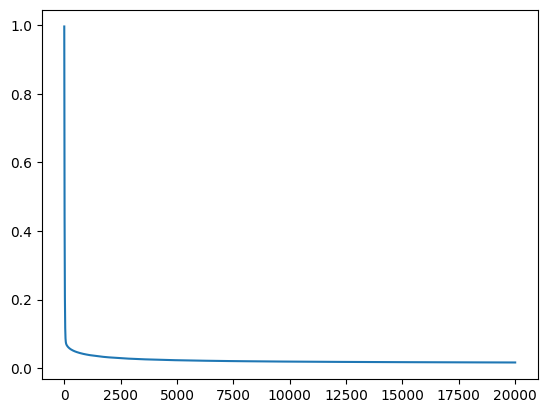

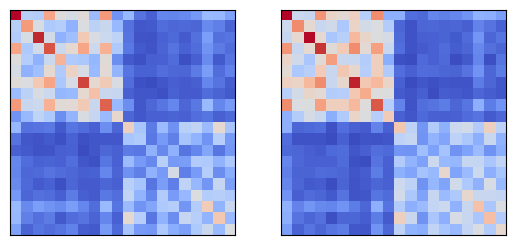

In [ ]:
plt.plot(test_losses)

perm = np.argsort(y_train)

plt.figure()
for l in range(L):
    plt.subplot(1, L, l+1)
    plt.imshow(H_avgs[l][perm][:, perm], cmap = 'coolwarm')
    plt.xticks([])
    plt.yticks([])
    print(jnp.mean(H_avgs[l][:P,:P])**2)

In [ ]:
phis, hat_phis, action_vals, aligns = linear_deep_Bayes(C, y_train, L, gamma, up_step_Phi = 0.0005, up_step_hatPhi = 0.001, steps = 500, inner_steps =100)

 step: 499, action: 0.7952001690864563

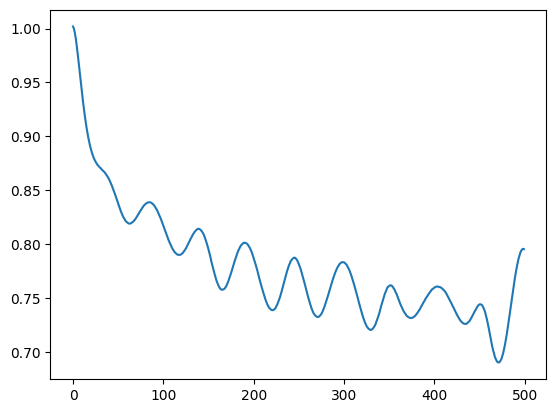

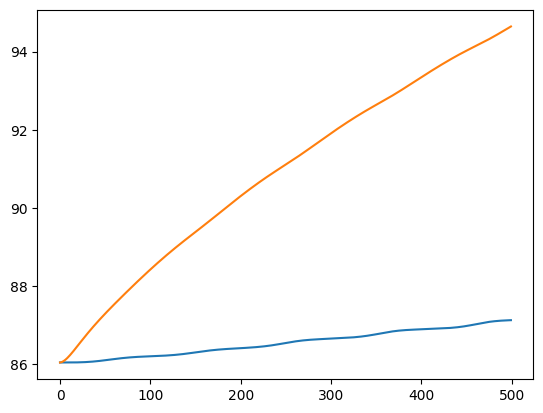

0.11200076
0.112618774


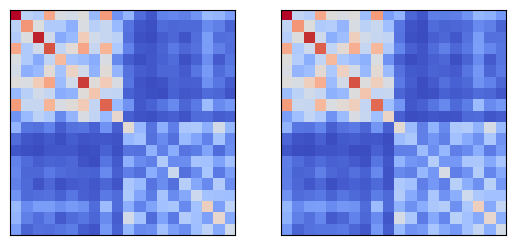

In [ ]:
aligns = jnp.array(aligns)

plt.plot(action_vals)
plt.show()

for l in range(L):
  plt.plot(aligns[:,l])
plt.show()

perm = np.argsort(y_train)
plt.figure()
for l in range(L):
  plt.subplot(1, L, l+1)
  plt.imshow(phis[l][perm][:,perm], cmap = 'coolwarm')
  plt.xticks([])
  plt.yticks([])
  print(jnp.mean(phis[l])**2)
plt.show()

phis_linear = phis.copy()

In [ ]:
for l in range(L):
  print(jnp.sum(phis[l] * H_avgs[l][:P,:P]) / jnp.sqrt( jnp.sum(phis[l]**2) * jnp.sum(H_avgs[l][:P,:P]**2) ))

0.99736136
0.98091054


In [9]:
L = 2
beta = 50
gamma = 0.5
seed = 0


N = 4096
eta = 5e-5
T = 20000

all_H_avgs = []
all_all_cs = []

seed = 0

gamma_values = [0.5]
train_source = {}
test_source = {}
params_source = {}

for gamma in gamma_values:
    train_losses, test_losses, H_avg, all_cs, params, Ws = deep_nonlinear(X, y, P, N, L, T, eta, gamma, beta, seed=seed)
    train_source[gamma] = train_losses
    test_source[gamma] = test_losses
    params_source[gamma] = params

In [10]:
np.mean(test_losses[5000:])

np.float32(0.038257975)

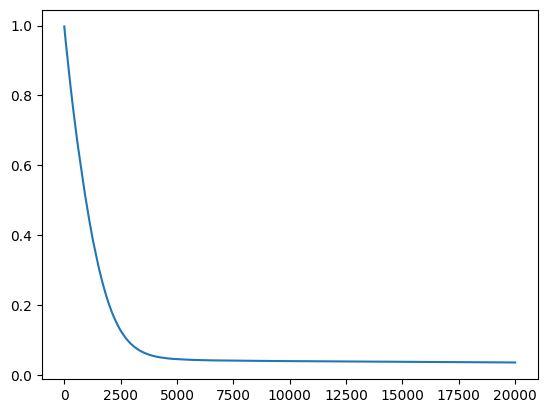

In [11]:
plt.plot(test_losses)

In [12]:
L = 2
seed = 0

phi, hat_phi, action_vals, aligns = nonlinear_deep_Bayes(C, y_train, L, gamma, beta, seed, up_step_Phi = 1e-5, up_step_hatPhi = 1e-3, steps = 20000, inner_steps =100)

 step: 19999, action: 2.290438652038574, grad_Phi: 0.6119385361671448, grad_hatPhi: 0.03681635484099388

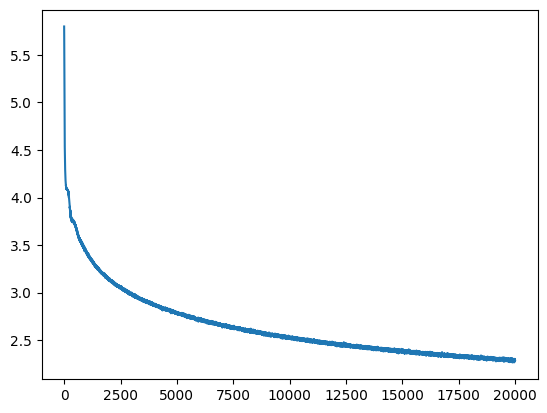

In [13]:
plt.plot(action_vals)

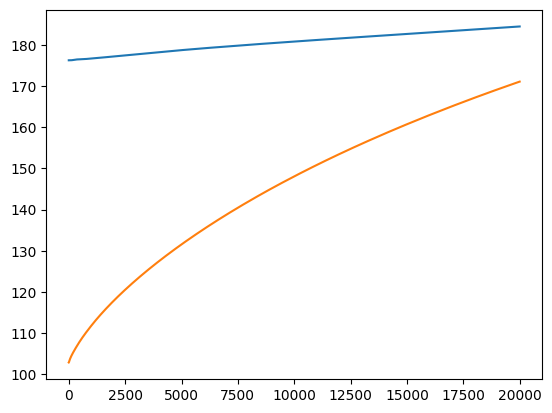

In [14]:
aligns = jnp.array(aligns)
for l in range(L):
  plt.plot(aligns[:,l])

Layer 1:
Alignment is 0.9440736174583435
Mean Th: 0.024199649691581726, Mean Exp: 0.03193909302353859
Layer 2:
Alignment is 0.8608020544052124
Mean Th: 0.010906881652772427, Mean Exp: 0.02975209802389145


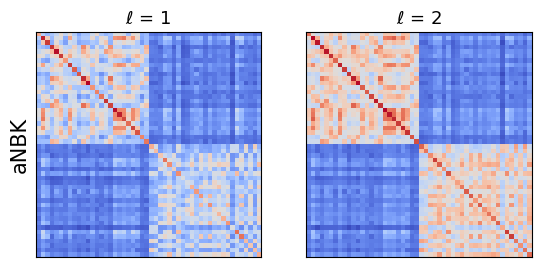

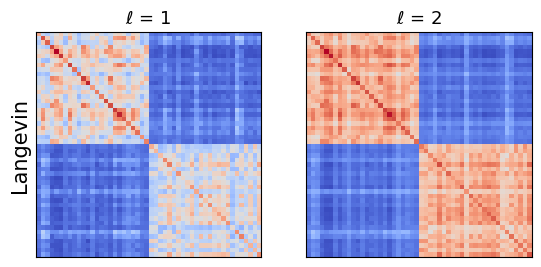

In [34]:
perm = np.argsort(y_train)
plt.figure()
for l in range(L):
    plt.subplot(1, L, l+1)
    if l == 0:
        plt.ylabel(r'aNBK', fontsize=15)
    plt.imshow(phi[l][perm][:, perm], cmap = 'coolwarm')
    plt.title(f'$\ell$ = {l+1}', fontsize = 13)
    plt.xticks([])
    plt.yticks([])
#plt.savefig(f'kernels_3HL_MLP_th.svg', dpi = 300, bbox_inches = 'tight')

plt.figure()
for l in range(L):
    plt.subplot(1, L, l+1)
    if l == 0:
        plt.ylabel(r'Langevin', fontsize=15)
    plt.imshow(H_avg[l][perm][:, perm], cmap = 'coolwarm')
    plt.title(f'$\ell$ = {l+1}', fontsize = 13)
    plt.xticks([])
    plt.yticks([])

for l in range(L):
    print(f"Layer {l+1}:")
    print(f'Alignment is {jnp.sum(phi[l] * H_avg[l]) / jnp.sqrt( jnp.sum(phi[l]**2) * jnp.sum(H_avg[l]**2) )}')
    print(f'Mean Th: {jnp.mean(phi[l]**2)}, Mean Exp: {jnp.mean(H_avg[l]**2)}')

#plt.savefig(f'kernels_3HL_MLP_exp.svg', dpi = 300, bbox_inches = 'tight')

In [14]:
L = 4
beta = 50
gamma = 0.5
seed = 0


N = 4096
eta = 5e-5
T = 20000

all_H_avgs = []
all_all_cs = []

seed = 0

gamma_values = [0.5]
train_source = {}
test_source = {}
params_source = {}

for gamma in gamma_values:
    train_losses, test_losses, H_avg, all_cs, params, Ws = deep_nonlinear(X, y, P, N, L, T, eta, gamma, beta, seed=seed)
    train_source[gamma] = train_losses
    test_source[gamma] = test_losses
    params_source[gamma] = params

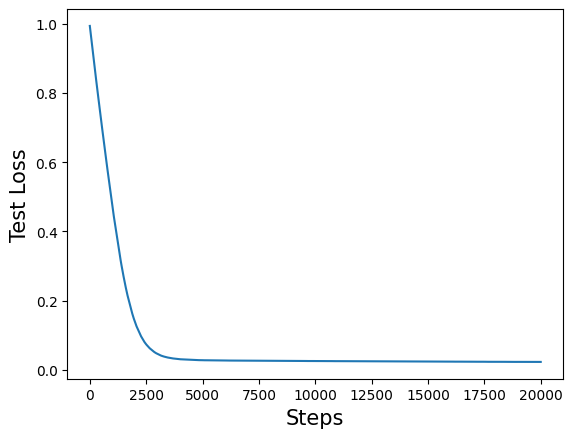

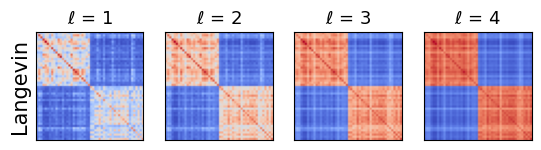

In [36]:
plt.plot(test_losses)
plt.ylabel('Test Loss', fontsize = 15)
plt.xlabel('Steps', fontsize = 15)


perm = np.argsort(y_train)
plt.figure()
for l in range(L):
    plt.subplot(1, L, l+1)
    if l == 0:
        plt.ylabel(r'Langevin', fontsize=15)
    plt.imshow(H_avg[l][perm][:, perm], cmap = 'coolwarm')
    plt.title(f'$\ell$ = {l+1}', fontsize = 13)
    plt.xticks([])
    plt.yticks([])

In [ ]:
L = 4
seed = 0

phi, hat_phi, action_vals, aligns = nonlinear_deep_Bayes(C, y_train, L, gamma, beta, seed, up_step_Phi = 1e-5, up_step_hatPhi = 1e-3, steps = 20000, inner_steps =100)

Text(0.5, 0, 'Steps')

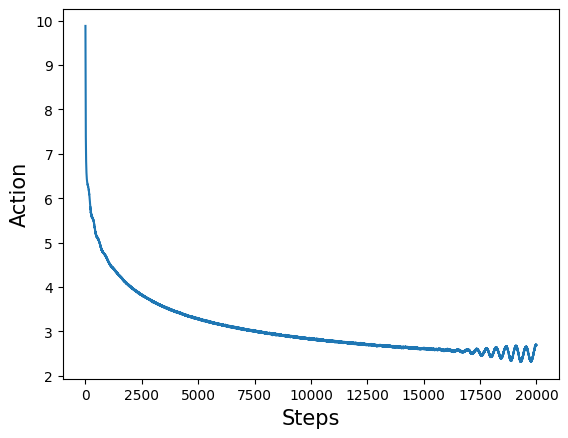

In [46]:
plt.plot(action_vals)
plt.ylabel('Action', fontsize = 15)
plt.xlabel('Steps', fontsize = 15)

Layer 1:
Alignment is 0.9672011733055115
Mean Th: 0.023988550528883934, Mean Exp: 0.028008965775370598
Layer 2:
Alignment is 0.8093632459640503
Mean Th: 0.008327529765665531, Mean Exp: 0.018330279737710953
Layer 3:
Alignment is 0.7272883057594299
Mean Th: 0.004740383941680193, Mean Exp: 0.02569061890244484
Layer 4:
Alignment is 0.8865335583686829
Mean Th: 0.005961899179965258, Mean Exp: 0.04140157997608185


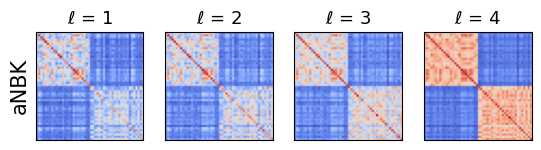

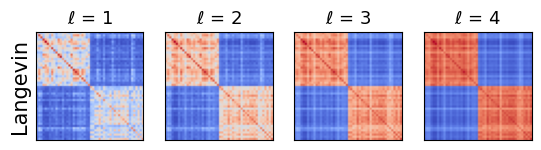

In [16]:
perm = np.argsort(y_train)
plt.figure()
for l in range(L):
    plt.subplot(1, L, l+1)
    if l == 0:
        plt.ylabel(r'aNBK', fontsize=15)
    plt.imshow(phi[l][perm][:, perm], cmap = 'coolwarm')
    plt.title(f'$\ell$ = {l+1}', fontsize = 13)
    plt.xticks([])
    plt.yticks([])
#lt.savefig(f'kernels_5HL_MLP_th.png', dpi = 300, bbox_inches = 'tight')

plt.figure()
for l in range(L):
    plt.subplot(1, L, l+1)
    if l == 0:
        plt.ylabel(r'Langevin', fontsize=15)
    plt.imshow(H_avg[l][perm][:, perm], cmap = 'coolwarm')
    plt.title(f'$\ell$ = {l+1}', fontsize = 13)
    plt.xticks([])
    plt.yticks([])

for l in range(L):
    print(f"Layer {l+1}:")
    print(f'Alignment is {jnp.sum(phi[l] * H_avg[l]) / jnp.sqrt( jnp.sum(phi[l]**2) * jnp.sum(H_avg[l]**2) )}')
    print(f'Mean Th: {jnp.mean(phi[l]**2)}, Mean Exp: {jnp.mean(H_avg[l]**2)}')

#plt.savefig(f'kernels_5HL_MLP_exp.png', dpi = 300, bbox_inches = 'tight')